# Packages: minimize for better structure

In [7]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
warnings.filterwarnings('ignore')

# Usage of KMeans to classify Responders/Non Responder

This is a notebook to map and structure the use of classifying with KMeans, in order to make an application that can implement epochs. For this notebook, it is desired to create a template for usage of epochs

Main Idea: (aim -> individual level)
- Initialize the data
- Train the data (PCA Dimensionality Reduction)
- These data points are classified to be responder or non responder. 
  - How is this done? Maybe start with a simple architecture so it trains fast for testing
  - It has to be unsupervised. Labels aren't given yet.


# Step 1: Initialize the data, and make sure this is done correct:
Explanation:

To begin, a folder directory and path are specified to access the files. These paths are joined using the os.path.join() function to handle the paths correctly and ensure they point to the right destination. Empty arrays are initialized for storing values. For instance, the patient_numbers list stores the IDs for each patient, which could be formatted like p1, p2, and so on.

A for loop is then used to iterate over each file in the directory, which corresponds to iterating through each patient. The filenames are processed using the os.fsdecode() function, and the patient number is extracted by splitting the filename based on underscores and selecting the first element. The patient number is then added to the patient_numbers array that was initialized earlier.

Next, the full directory of each patient file is constructed by joining the base path with the specific filename. This ensures that the data can be properly accessed. The data itself is read from the CSV files using pd.read_csv(), as the files are in CSV format.

After loading the data, some preprocessing steps are applied. Column names are adjusted, and any text-based attributes are converted into numerical values for easier handling. A set of specific columns is chosen for standardization, which is done using the StandardScaler from sklearn. This step ensures that features are on the same scale, preventing large values from dominating the training process. By standardizing, the mean of each column is set to 0, and the standard deviation is set to 1, ensuring uniformity in the dataset.


In [8]:
path = '5_csv'
folder = 'C:\\Users\\RJEN0307\\Desktop\\Bachelorprojekt\\Data\\fif files\\epochs_csv\\'

full_path = os.path.join(folder, path)


patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0]  # This will give 'p3' from 'p3_features.csv'
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)
    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})
    standarize_list = ['PSD Delta', 'PSD Delta_N', 'PSD Theta', 'PSD Theta_N', 'PSD Alpha', 'PSD Alpha_N', 'PSD Beta', 'PSD Beta_N', 'PSD Gamma', 'PSD Gamma_N', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']

    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[standarize_list] = sklearn.preprocessing.StandardScaler().fit(data[standarize_list]).transform(data[standarize_list])

    patient_data[patient_number] = data
    print(f'Loaded data for patient {patient_number}')

print(patient_data['p10'])
print(f'Loaded data for patient {patient_number}')

Loaded data for patient p100
Loaded data for patient p10
Loaded data for patient p11
Loaded data for patient p12
Loaded data for patient p13
Loaded data for patient p14
Loaded data for patient p15
Loaded data for patient p16
Loaded data for patient p17
Loaded data for patient p18
Loaded data for patient p19
Loaded data for patient p20
Loaded data for patient p21
Loaded data for patient p22
Loaded data for patient p23
Loaded data for patient p24
Loaded data for patient p25
Loaded data for patient p27
Loaded data for patient p28
Loaded data for patient p29
Loaded data for patient p2
Loaded data for patient p30
Loaded data for patient p31
Loaded data for patient p32
Loaded data for patient p33
Loaded data for patient p34
Loaded data for patient p35
Loaded data for patient p36
Loaded data for patient p37
Loaded data for patient p38
Loaded data for patient p39
Loaded data for patient p3
Loaded data for patient p40
Loaded data for patient p41
Loaded data for patient p42
Loaded data for patie

# Step 2: Initialize the Unsupervised learning
This is the most important step.

For testing purpose, a simple model is first initialized. The K-means algorithm looks to create K clusters, and it uses the 'mean' or center for the cluster to compare distances to data points. From this, it classifies the nearby data points to the cluster which has the closest center. It is important that it looks at each patient, and not all the data at the same time. Since the initialization of the data is structured such that it stores each patients data seperately in the patient_data dictionary, the values can be extract from this. 

To make life easier for ourselves, functions are created to do so. The purpose of the function "cluster_training" is simply to initialize the KMeans algorithm, such that the model can be evaluated. The second function "clustering_training_and_plotting" is used to plot the clusterings.

The function below initializes the K-Means classification algorithm, and returns the labels the model has assigned to each feature. This will be used for analytical purposes

In [9]:
def cluster_training(patient):
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto") # Model initialization
    patient_traindata = patient_data[patient]
    kmeans.fit(patient_traindata)
    print(kmeans.labels_)
    return kmeans.labels_

The function "clustering_training_and_plotting" uses PCA to dimensionality reduce the data, and then uses these values to classify with the K-Means algorithm. To interpret and verify the results, plotting is very important.

The plotting part of the function includes various techniques to explore the data:
 - gaussian_filter1d can be used to smooth the EEG curve. Change sigma value in function head.
 - Uses colors to show time intervals for different stimuli. Done by using the first and last index of a given event
 - Patient can be chosen by changing the patient variable to string of format "px" where x $\in [1,80]$
 - Creates two plots
    - The K-Means classification visualized
    - The classified data points on the EEG data


In [10]:
def clustering_training_and_plotting(patient, sigma=0.1):
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
    
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(patient_data[patient])

    

    kmeans.fit(reduced_data)
    
    labels = kmeans.labels_
    
    # ----------- PLOTTING ----------- 
    patient_data_with_labels = patient_data[patient].copy()
    patient_data_with_labels['Cluster Label'] = labels

    fig, ax = plt.subplots(figsize=(10, 5))

    cluster_colors = ['red' if label == 0 else 'blue' for label in labels]

    scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_colors, marker='o', edgecolor='black', linewidth=0.5, s=30)
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', marker='x', label='Cluster Centers')
    ax.set_title(f"Clusters for Patient {patient}", fontsize=10)  
    ax.grid(False)

    fig, ax2 = plt.subplots(figsize=(10, 5))
    
    time = np.arange(len(patient_data_with_labels))
    delta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Delta'], sigma=sigma)
    theta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Theta'], sigma=sigma)
    beta_smooth = gaussian_filter1d(patient_data_with_labels['PSD Beta'], sigma=sigma)
    gamma_smooth = gaussian_filter1d(patient_data_with_labels['PSD Gamma'], sigma=sigma)
    
    ax2.plot(time, delta_smooth, label='Delta (0.5-4 Hz)', color='black', linewidth=1)
    ax2.plot(time, theta_smooth, label='Theta (4-8 Hz)', color='gray', linewidth=1)
    ax2.plot(time, beta_smooth, label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
    ax2.plot(time, gamma_smooth, label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

    ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
    ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

    stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
    
    event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
    
    for _, group_data in patient_data_with_labels.groupby(event_groups):
        stimulus_value = group_data['Event'].iloc[0]
        if stimulus_value in stimuli_colors:
            start_idx = group_data.index[0]
            end_idx = group_data.index[-1]
            start_time = time[start_idx]
            end_time = time[end_idx]
            ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster 0', markerfacecolor='red', markersize=8, markeredgecolor='black'),
                       Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=8, markeredgecolor='black')]
    ax2.legend(handles=legend_elements, fontsize=8, loc='upper right')

    ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Feature Value')
    ax2.grid(False)
    silhouette_avg = silhouette_score(reduced_data, labels)
    print(f'Silhouette Score: {silhouette_avg}')

    db_score = davies_bouldin_score(reduced_data, labels)
    print(f'Davies-Bouldin Index: {db_score}')

    plt.tight_layout()
    plt.show()


# Case Usage of K-Means Algorithm (k=2)
Final step is to show the plots, and make interpretation from these. Below, you can see two plots.

The first plot is a visualization of the first two principle components with the data points and their classes as colors. (Blue = 1, Red = 0) In the second plot, the classfied data points can be seen plotted onto a graph of the EEG data. This plot also includes the time intervals for different stimuli.



Silhouette Score: 0.9617583912336901
Davies-Bouldin Index: 0.05602679678919502


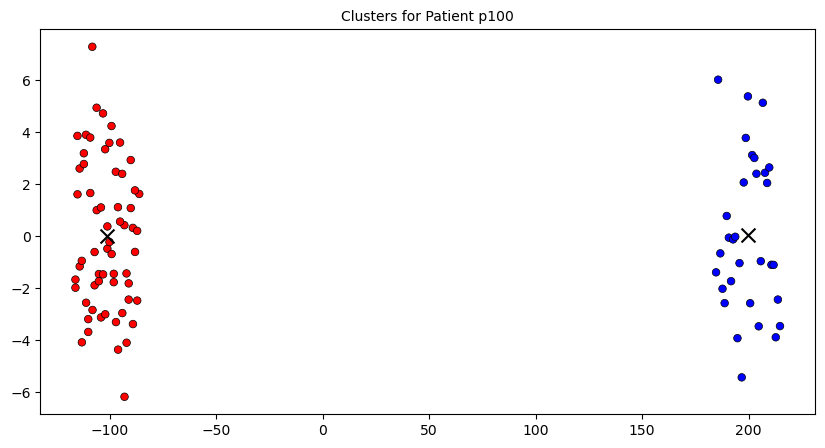

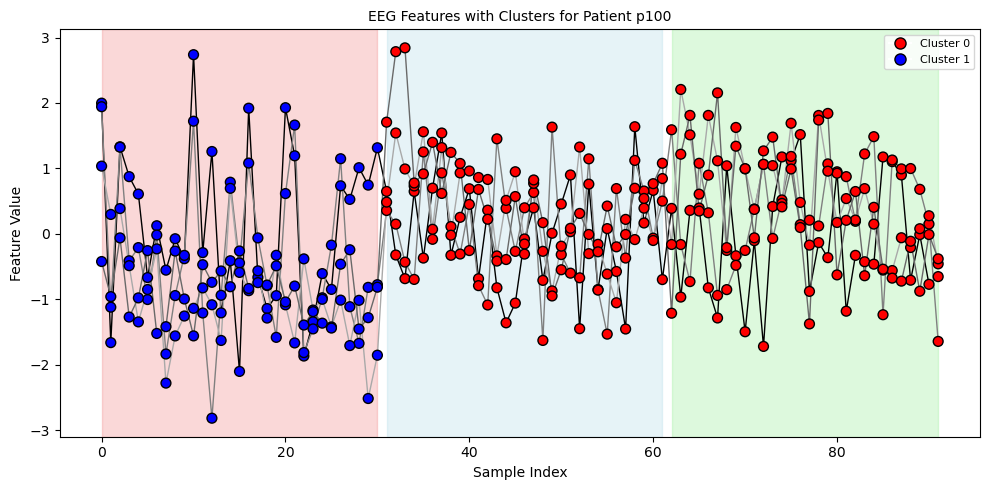

In [11]:
clustering_training_and_plotting('p100')

# Evaluation of the Unsupervised Model
When changing certain aspects of a model, it is important to evaluate if the performance was made better or worse. Since this is a unsupervised classification task, it is hard to evaluate if it correctly predict the classes. This is due to the fact that the true labels are unknown. 

Therefore, the Silhouette score is implemented. This method gives an estimate as to how well the model is performing, by calculating the the ratio between how close a given data point is to it's own cluster, and how close it is to another cluster. This is also reffered to as the balance between cohesion and separation. The value range from [-1,1] where 1 is a perfect clustering and -1 is a bad clustering.

To make sure that the Silhouette score isn't the only indicator, the Davies Bouldin Score was implemented. This calculation describes how compact and well-seperated the clusters are. This is especially important, since our hypothesis clearly divides the two groups of responders/non-responders.


In [12]:
all_sil_scores = []
all_davies_score = []
for patient in patient_numbers:
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(patient_data[patient])
    kmeans.fit(reduced_data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(reduced_data, labels)
    davies_avg = davies_bouldin_score(reduced_data, labels)
    all_sil_scores.append(silhouette_avg)
    all_davies_score.append(davies_avg)

print(f'Max Silhouette Score: {np.max(all_sil_scores)}', f'Patient Number: {patient_numbers[np.argmax(all_sil_scores)]}')
print(f'Max Silhouette Score: {np.max(all_davies_score)}', f'Patient Number: {patient_numbers[np.argmax(all_davies_score)]}')
all_davies_score.sort()
print(all_davies_score)
# sorted scores with patient numbers
#sorted_scores = sorted(all_davies_score, reverse=True)
#print(sorted_scores)

sorted_patients = []
for score in sorted_patients:
    index = all_davies_score.index(score)
    sorted_patients.append(patient_numbers[index])

print(sorted_patients)

Max Silhouette Score: 0.9617583912336901 Patient Number: p100
Max Silhouette Score: 0.48560599408625205 Patient Number: p15
[0.05602679678919502, 0.44375198771917174, 0.4553735632838619, 0.4564773887794592, 0.4568864979882687, 0.4581180343200581, 0.4587866658561515, 0.4592035564410439, 0.4607359324316993, 0.46079928184203667, 0.4632034516586234, 0.4636702824816059, 0.4643593452040815, 0.4651966624341256, 0.4662827710213354, 0.46726085373850273, 0.4674779877153651, 0.46791811603307126, 0.46801252340577104, 0.46833650366983876, 0.46849130944023387, 0.46852144689476993, 0.46856571704136063, 0.4686984781812804, 0.4689515448854053, 0.46962443578482393, 0.4698935550485302, 0.47038695765329197, 0.47049665724089135, 0.4705114723403399, 0.4706606835004423, 0.4707192753712027, 0.4708963945590984, 0.4709148372565958, 0.47114167083795455, 0.4711859193111816, 0.47124755623649794, 0.4713284906337837, 0.4714390553368883, 0.4716536721407126, 0.47168794415316523, 0.4717613777206736, 0.4718069815723905,